# 데이터 가져오기

In [3]:
!kaggle competitions download -c titanic

titanic.zip: Skipping, found more recently modified local copy (use --force to force download)


In [4]:
!cd titanic.zip

zsh:cd:1: not a directory: titanic.zip


In [2]:
from pathlib import Path
import numpy as np
import pandas as pd
import shutil
 
filename='titanic.zip'
extrac_dir='titanic'
archive_format='zip'
shutil.unpack_archive(filename, extrac_dir, archive_format)

/Users/yoonsjin/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/yoonsjin/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


In [6]:
import os   
os.listdir('titanic')
os.getcwd()

'/Users/yoonsjin/Hands on Machine Learning/Ch3'

In [6]:
train_set=pd.read_csv('titanic/train.csv')
test_set=pd.read_csv('titanic/test.csv')

# 데이터 이해를 위한 분석

In [55]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


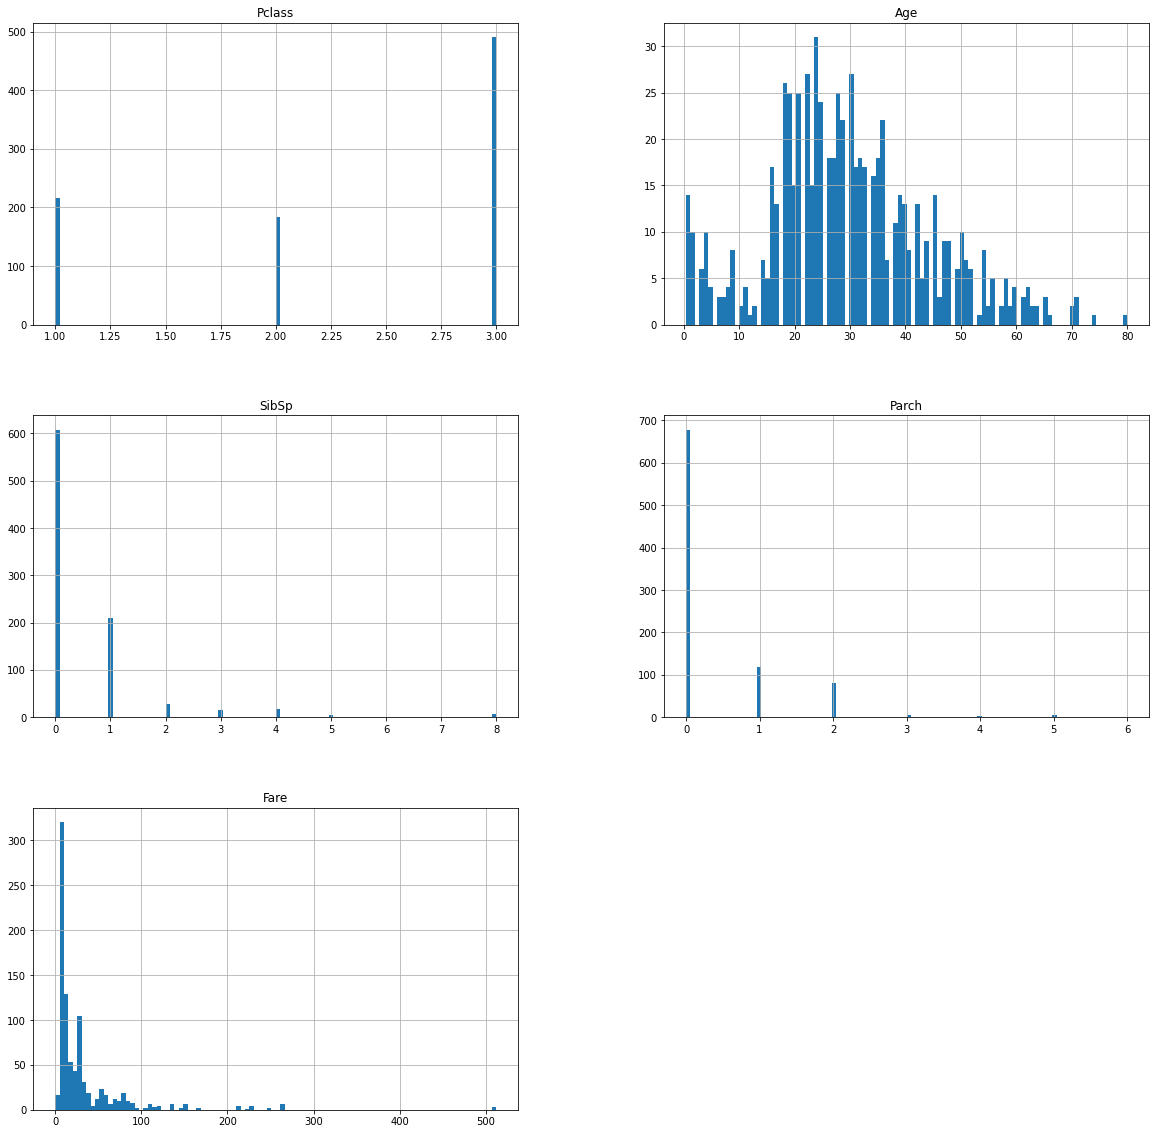

In [26]:
import matplotlib.pyplot as plt

train_set.hist(bins=100,figsize=(20,20))
plt.show()

In [7]:
#명시적으로 PassengerId 열을 인덱스 열로 설정
train_set=train_set.set_index("PassengerId")
test_set=test_set.set_index("PassengerId")

# 파이프라인
최종적으로 누락된 값을 대체하고 스케일을 조정하는 간단한 파이프라인

In [102]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 1 to 891
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    891 non-null    int64  
 1   Name      891 non-null    object 
 2   Sex       891 non-null    object 
 3   Age       714 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Ticket    891 non-null    object 
 7   Fare      891 non-null    float64
 8   Cabin     204 non-null    object 
 9   Embarked  889 non-null    object 
dtypes: float64(2), int64(3), object(5)
memory usage: 76.6+ KB


In [8]:
train_set_label=train_set["Survived"]
train_set=train_set.drop("Survived",axis=1)

In [15]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.impute import SimpleImputer

num_missing_attribs=["Pclass","Age","SibSp","Parch","Fare"]
cat_attribs_to_num=["Sex","Embarked"]
cat_attribs_orig=["Name","Ticket","Cabin"]

num_pipeline=Pipeline([
    ("imputer",SimpleImputer(strategy="median")),
    ("scaler",StandardScaler())
])
cat_pipeline=Pipeline([
    ("ordinal_encoder" ,OrdinalEncoder(handle_unknown="error")),
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("cat_encoder",OneHotEncoder(sparse_output=False)),
])

preprocess_pipeline=ColumnTransformer([
    ("num",num_pipeline,num_missing_attribs),
    ("cat",cat_pipeline,cat_attribs_to_num),
])

In [16]:
train_set_prepared=preprocess_pipeline.fit_transform(train_set)

In [17]:
train_set_prepared.shape

(891, 10)

In [18]:
preprocess_pipeline.get_feature_names_out()

array(['num__Pclass', 'num__Age', 'num__SibSp', 'num__Parch', 'num__Fare',
       'cat__Sex_0.0', 'cat__Sex_1.0', 'cat__Embarked_0.0',
       'cat__Embarked_1.0', 'cat__Embarked_2.0'], dtype=object)

# 훈련

In [19]:
#RandomForestClassifier 테스트
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

forest_clf=RandomForestClassifier(n_estimators=100, random_state=42)
forest_clf.fit(train_set_prepared,train_set_label)

RandomForestClassifier(random_state=42)

In [20]:
X_test=preprocess_pipeline.transform(test_set)
y_pred=forest_clf.predict(X_test)

In [22]:
forest_scores=cross_val_score(forest_clf,train_set_prepared, train_set_label,cv=10)
forest_scores.mean()

0.8137827715355804

In [24]:
#SVC
from sklearn.svm import SVC

svm_clf=SVC(gamma="auto")
svm_scores=cross_val_score(svm_clf, train_set_prepared,train_set_label,cv=10)
svm_scores.mean()

0.8238077403245943

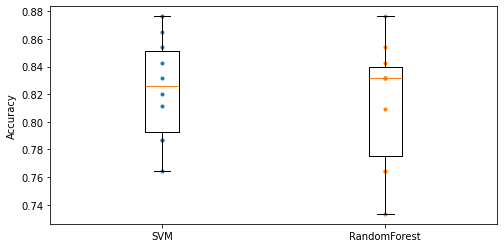

In [31]:
#각 모델에 대한 모든 10개의 점수를 하위 및 상위 사분위수를 강조하는 박스 플롯과 점수의 범위 그리기
plt.figure(figsize=(8,4))
plt.plot([1]*10, svm_scores, ".")
plt.plot([2]*10, forest_scores, ".")
plt.boxplot([svm_scores, forest_scores],labels=("SVM","RandomForest"))
plt.ylabel("Accuracy")
plt.show()

# 여러 가지 방법 시도해보기

In [40]:
train_set['Survived']=train_set_label

In [42]:
#숫자 특성을 범주 특성으로 변환
train_set["AgeBucket"]=train_set["Age"]//15*15
train_set[["AgeBucket","Survived"]].groupby(['AgeBucket']).mean()

,Survived
AgeBucket,
0.0,0.576923
15.0,0.362745
30.0,0.423256
45.0,0.404494
60.0,0.240000
75.0,1.000000


In [46]:
#SibSp와 Parch 특성을 합치기
train_set["RelativesOnboard"]=train_set["SibSp"]+train_set["Parch"]
train_set[["RelativesOnboard","Survived"]].groupby(['RelativesOnboard']).mean()

,Survived
RelativesOnboard,
0,0.303538
1,0.552795
2,0.578431
3,0.724138
4,0.200000
5,0.136364
6,0.333333
7,0.000000
10,0.000000
